# Wind farm optimisation

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
import cartopy.crs as ccrs
import contextily as cx
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar

from h2ss import data as rd
from h2ss import functions as fns
from h2ss import optimisation as opt
from h2ss import capacity as cap

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

## Constraints

In [4]:
# 500 m buffer - suggested in draft OREDP II p. 108
wells, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

# the shapes are used as is without a buffer - suggested for renewable energy
# test site areas in draft OREDP II p. 109
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

# 1 NM (1,852 m) buffer - suggested in draft OREDP II p. 108
shipping, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

# Archaeological Exclusion Zones recommendation - 100 m buffer
shipwrecks, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

# 750 m buffer - suggested in draft OREDP II p. 109-111
cables, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

edge_buffer = fns.constraint_halite_edge(dat_xr=ds)

## Zones of interest

In [5]:
# height = 85 m, 500 m <= depth <= 2,000 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds,
    constraints={"height": 155, "min_depth": 1000, "max_depth": 1500},
)

## Exclusions

In [6]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 929
------------------------------------------------------------
Exclude salt formation edges...
Number of potential caverns: 901
Caverns excluded: 3.01%
------------------------------------------------------------
Exclude frequent shipping routes...
Number of potential caverns: 406
Caverns excluded: 56.30%
------------------------------------------------------------
Exclude subsea cables...
Number of potential caverns: 404
Caverns excluded: 56.51%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 357
Caverns excluded: 61.57%
------------------------------------------------------------
Exclude exploration wells...
Number of potential caverns: 357
Caverns excluded: 61.57%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 357
Caverns excluded: 61.57%
------------------------------------------------------------


In [7]:
# label caverns by height and depth
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[155],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

## Capacity [GWh]

In [8]:
caverns["cavern_volume"] = cap.cavern_volume(height=caverns["cavern_height"])
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_volume"]
)

caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(thickness_overburden=caverns["TopDepthSeabed"])

caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

(
    caverns["working_mass"],
    caverns["mass_operating_min"],
    caverns["mass_operating_max"],
) = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

In [9]:
# total capacity
caverns[["capacity"]].sum().iloc[0]

33667.733688952736

In [10]:
# total working mass
caverns[["working_mass"]].sum().iloc[0]

1010368800.2686715

## Power curve [MW] and Weibull wind speed distribution

In [11]:
# extract data for wind farms at 150 m
weibull = fns.read_weibull_data(
    data_path_weibull=os.path.join(
        "data", "weibull-parameters-wind-speeds", "Weibull_150m_params_ITM.zip"
    ),
    data_path_wind_farms=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

In [12]:
weibull

,Name,"(c, min)","(c, max)","(c, mean)","(k, min)","(k, max)","(k, mean)"
0,Codling Wind Park,10.3,10.8,10.550000,1.9,2.0,1.95
1,Dublin Array,9.9,10.6,10.292857,1.9,2.0,1.95
2,North Irish Sea Array (NISA),10.4,11.1,10.806250,2.1,2.2,2.12


In [13]:
# generate Weibull distribution
ref_data = {}
for n in weibull["Name"]:
    ref_data[n] = {}
    ref_data[n]["wind_speed"] = [0 + 0.01 * n for n in range(3100)]
    ref_data[n]["power_curve"] = []
    ref_data[n][n] = []
    for v in ref_data[n]["wind_speed"]:
        ref_data[n]["power_curve"].append(opt.ref_power_curve(v=v))
        ref_data[n][n].append(
            opt.weibull_probability_distribution(
                v=v,
                k=weibull[weibull["Name"] == n][("k", "mean")].iloc[0],
                c=weibull[weibull["Name"] == n][("c", "mean")].iloc[0],
            )
        )
    ref_data[n] = pd.DataFrame(ref_data[n])

In [14]:
ref_data = pd.concat(ref_data.values(), axis=1).T.drop_duplicates().T

In [15]:
ref_data.head()

,wind_speed,power_curve,Codling Wind Park,Dublin Array,North Irish Sea Array (NISA)
0,0.00,0.0,0.000000,0.000000,0.000000
1,0.01,0.0,0.000248,0.000260,0.000079
2,0.02,0.0,0.000479,0.000503,0.000171
3,0.03,0.0,0.000705,0.000739,0.000269
4,0.04,0.0,0.000926,0.000972,0.000371


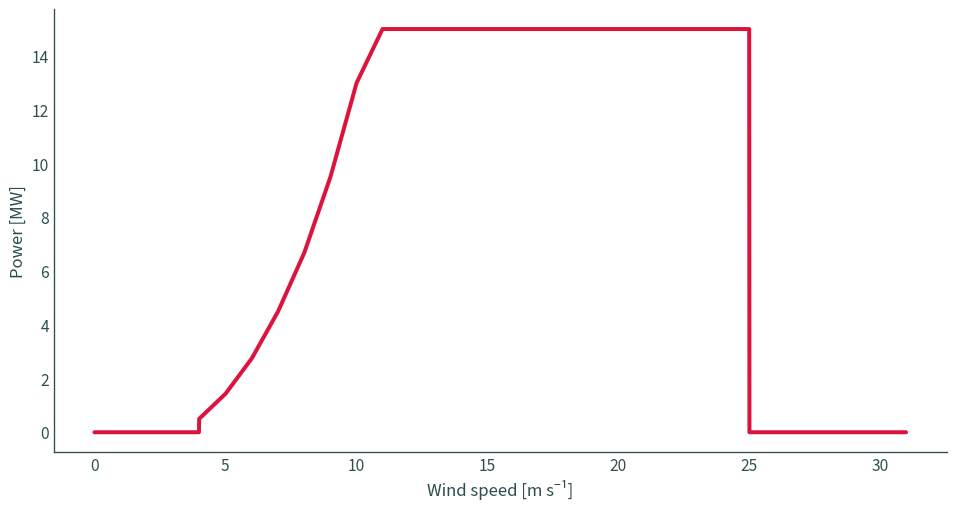

In [16]:
ax = ref_data.plot(
    x="wind_speed",
    y="power_curve",
    ylabel="Power [MW]",
    linewidth=3,
    color="crimson",
    figsize=(12, 6),
    legend=False,
)
ax.set_xlabel("Wind speed [m s\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}]")
ax.set_ylabel("Power [MW]")
sns.despine()

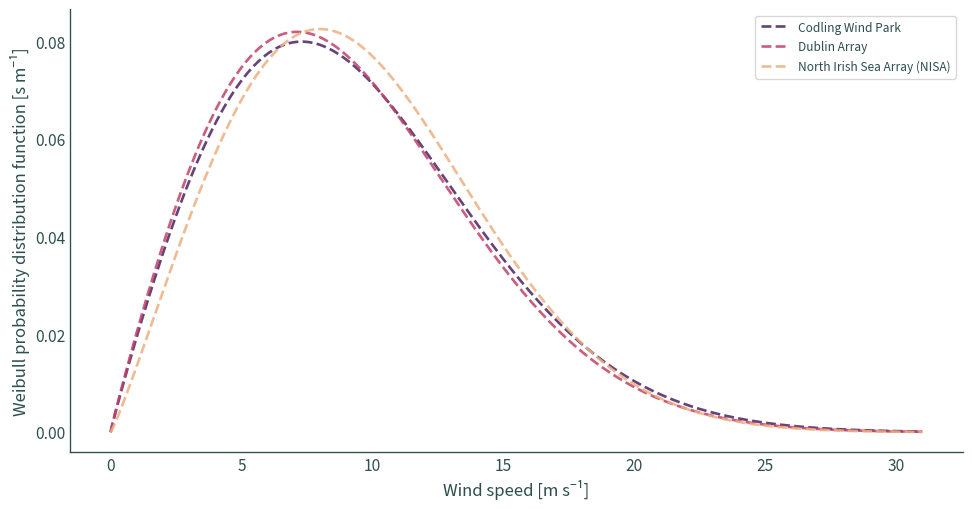

In [17]:
ax = ref_data.drop(columns=["power_curve"]).plot(
    x="wind_speed",
    cmap="flare_r",
    figsize=(12, 6),
    linestyle="dashed",
    linewidth=2,
    alpha=0.85,
)
ax.set_xlabel("Wind speed [m s\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}]")
ax.set_ylabel(
    "Weibull probability distribution function "
    "[s m\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}]"
)
sns.despine()

## Annual energy production [MWh]

In [18]:
# max wind farm capacity
weibull["capacity"] = [1300, 824, 500]

In [19]:
# number of 15 MW turbines, rounded down to the nearest integer
weibull["n_turbines"] = (weibull["capacity"] / 15).astype(int)

In [20]:
data = []
integral = []
abserr = []
for n in weibull["Name"]:
    aepwt = opt.annual_energy_production(
        n_turbines=weibull[weibull["Name"] == n]["n_turbines"].iloc[0],
        k=weibull[weibull["Name"] == n][("k", "mean")].iloc[0],
        c=weibull[weibull["Name"] == n][("c", "mean")].iloc[0],
    )
    data.append(aepwt)

In [21]:
data = pd.DataFrame(data)
data.columns = ["AEP", "integral", "abserr"]

In [22]:
data = pd.concat([weibull, data], axis=1)

## Annual hydrogen production [kg]

In [23]:
data["AHP"] = opt.annual_hydrogen_production(aep=data["AEP"])

### AHP as a proportion of the total working mass

In [24]:
data["AHP_frac"] = data["AHP"] / caverns[["working_mass"]].sum().iloc[0]

In [25]:
data

,Name,"(c, min)","(c, max)","(c, mean)","(k, min)","(k, max)","(k, mean)",capacity,n_turbines,AEP,integral,abserr,AHP,AHP_frac
0,Codling Wind Park,10.3,10.8,10.550000,1.9,2.0,1.95,1300,86,5.668353e+06,8.360106,4.565276e-07,9.985922e+07,0.098834
1,Dublin Array,9.9,10.6,10.292857,1.9,2.0,1.95,824,54,3.471511e+06,8.154141,4.675453e-07,6.115752e+07,0.060530
2,North Irish Sea Array (NISA),10.4,11.1,10.806250,2.1,2.2,2.12,500,33,2.291175e+06,8.806387,4.437917e-07,4.036357e+07,0.039949


## Calculate distance between caverns and the wind farms and injection point [km]

In [26]:
wind_farms["Name_"] = wind_farms["Name"].str.split(expand=True)[0]
wind_farms = wind_farms.dissolve("Name_").reset_index()

In [27]:
# Dublin Port coordinates (Dinh et al. - injection point)
injection_point = gpd.GeoSeries(
    [Point(-(6 + 12 / 60), 53 + 21 / 60)], crs=4326
)
injection_point = injection_point.to_crs(rd.CRS)

In [30]:
distance_ip = []
for j in range(len(caverns)):
    distance_ip.append(
        injection_point.distance(
            caverns.iloc[[j]]["geometry"], align=False
        ).values[0]
        / 1000
    )
caverns["distance_ip"] = distance_ip

In [31]:
distance_wf = {}
for i in range(len(wind_farms)):
    distance_wf[wind_farms["Name_"][i]] = []
    for j in range(len(caverns)):
        distance_wf[wind_farms["Name_"][i]].append(
            (
                wind_farms.iloc[[i]]
                .distance(caverns.iloc[[j]]["geometry"], align=False)
                .values[0]
                / 1000
                + caverns.iloc[[j]]["distance_ip"].values[0]
            )
        )
    caverns[f"distance{wind_farms['Name_'][i]}"] = distance_wf[
        wind_farms["Name_"][i]
    ]

In [32]:
caverns = caverns.rename(columns={"distanceNorth": "distanceNISA"})

## CAPEX for pipeline [€ km⁻¹]

In [33]:
# 1,000 MW electrolyser
capex = opt.capex_pipeline(e_cap=1000)

In [34]:
capex

1414063.9561690202

## LCOT for pipeline [€ kg⁻¹]

In [35]:
for wf in ["Codling", "Dublin", "NISA"]:
    caverns[f"LCOT_{wf}"] = opt.lcot_pipeline(
        capex=capex,
        transmission_distance=caverns[f"distance{wf}"],
        ahp=data[data["Name"].str.contains(wf)]["AHP"].values[0],
    )

In [36]:
caverns[
    [
        "cavern_depth",
        "working_mass",
        "capacity",
        "distance_ip",
        "distanceCodling",
        "distanceDublin",
        "distanceNISA",
        "LCOT_Codling",
        "LCOT_Dublin",
        "LCOT_NISA",
    ]
].describe()

,cavern_depth,working_mass,capacity,distance_ip,distanceCodling,distanceDublin,distanceNISA,LCOT_Codling,LCOT_Dublin,LCOT_NISA
count,357.000000,3.570000e+02,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,1230.733769,2.830165e+06,94.307377,30.107326,58.508685,44.324537,50.611314,0.067874,0.084071,0.145350
std,141.546802,2.406478e+05,8.018921,6.869687,12.173576,13.234438,8.076779,0.014063,0.024964,0.023084
min,1000.558475,2.422773e+06,80.732188,14.294115,33.090298,19.586181,37.904683,0.038510,0.037408,0.109034
25%,1103.648373,2.614863e+06,87.133031,23.776583,52.805023,34.364489,41.856734,0.061285,0.065284,0.120329
50%,1225.320306,2.829205e+06,94.275414,32.239103,60.992121,48.468441,51.692175,0.070743,0.091888,0.148439
75%,1347.560593,3.032095e+06,101.036147,35.459512,66.912492,53.762811,57.795720,0.077583,0.101874,0.165883
max,1499.035241,3.267678e+06,108.886301,42.751238,80.403976,69.418567,64.288068,0.093168,0.131406,0.184438


In [48]:
def plot_map_alt(
    dat_xr,
    cavern_df,
    zones_gdf,
    column,
    classes,
    colours,
    labels,
    fontsize=11.5,
):
    """
    Helper function to plot caverns within the zones of interest
    """
    plt.figure(figsize=(20, 11.5))
    axis = plt.axes(projection=ccrs.epsg(rd.CRS))
    legend_handles = []

    # halite boundary - use buffering to smooth the outline
    shape = rd.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)
    shape.plot(
        ax=axis,
        edgecolor="darkslategrey",
        color="none",
        linewidth=2,
        alpha=0.5,
        zorder=2,
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            edgecolor="darkslategrey",
            label="Kish Basin boundary",
            alpha=0.5,
        )
    )

    zones_gdf.plot(
        ax=axis, zorder=1, linewidth=0, facecolor="white", alpha=0.45
    )
    zones_gdf.plot(
        ax=axis,
        zorder=2,
        edgecolor="slategrey",
        linestyle="dotted",
        linewidth=1.25,
        facecolor="none",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linestyle="dotted",
            edgecolor="slategrey",
            label="Area of interest",
            linewidth=1.25,
        )
    )

    pd.concat(
        [wells_b, shipwrecks_b, shipping_b, cables_b, wind_farms]
    ).dissolve().clip(shape).plot(
        ax=axis,
        facecolor="none",
        linewidth=0.65,
        edgecolor="slategrey",
        zorder=2,
        alpha=0.5,
        hatch="//",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            hatch="//",
            edgecolor="slategrey",
            label="Exclusion",
            alpha=0.65,
            linewidth=0.5,
        )
    )

    legend_handles.append(
        mpatches.Patch(label="Pipeline LCOT [€ kg⁻¹]", visible=False)
    )

    for x, y, z in zip(classes, colours, labels):
        if x == 0:
            c = cavern_df[cavern_df[column] < x + 0.04]
        elif x == 0.16:
            c = cavern_df[cavern_df[column] >= x]
        else:
            c = cavern_df[
                (cavern_df[column] >= x) & (cavern_df[column] < x + 0.04)
            ]
        if len(c) > 0:
            c.centroid.plot(
                ax=axis,
                zorder=3,
                linewidth=0,
                marker=".",
                # markersize=markersize,
                color=sns.color_palette("flare", 256)[y],
            )
        legend_handles.append(
            mpatches.Patch(
                facecolor=sns.color_palette("flare", 256)[y], label=z
            )
        )

    plt.xlim(shape.bounds["minx"][0] - 1000, shape.bounds["maxx"][0] + 1000)
    plt.ylim(shape.bounds["miny"][0] - 1000, shape.bounds["maxy"][0] + 1000)

    cx.add_basemap(
        axis, crs=rd.CRS, source=cx.providers.CartoDB.VoyagerNoLabels
    )
    axis.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
        xlabel_style={"fontsize": fontsize},
        ylabel_style={"fontsize": fontsize},
    )
    axis.add_artist(
        ScaleBar(
            1,
            box_alpha=0,
            location="lower right",
            color="darkslategrey",
            width_fraction=0.0075,
            font_properties={"size": fontsize},
        )
    )
    plt.legend(
        loc="lower right",
        bbox_to_anchor=(1, 0.05),
        handles=legend_handles,
        fontsize=fontsize,
    )

    plt.tight_layout()
    plt.show()

Codling


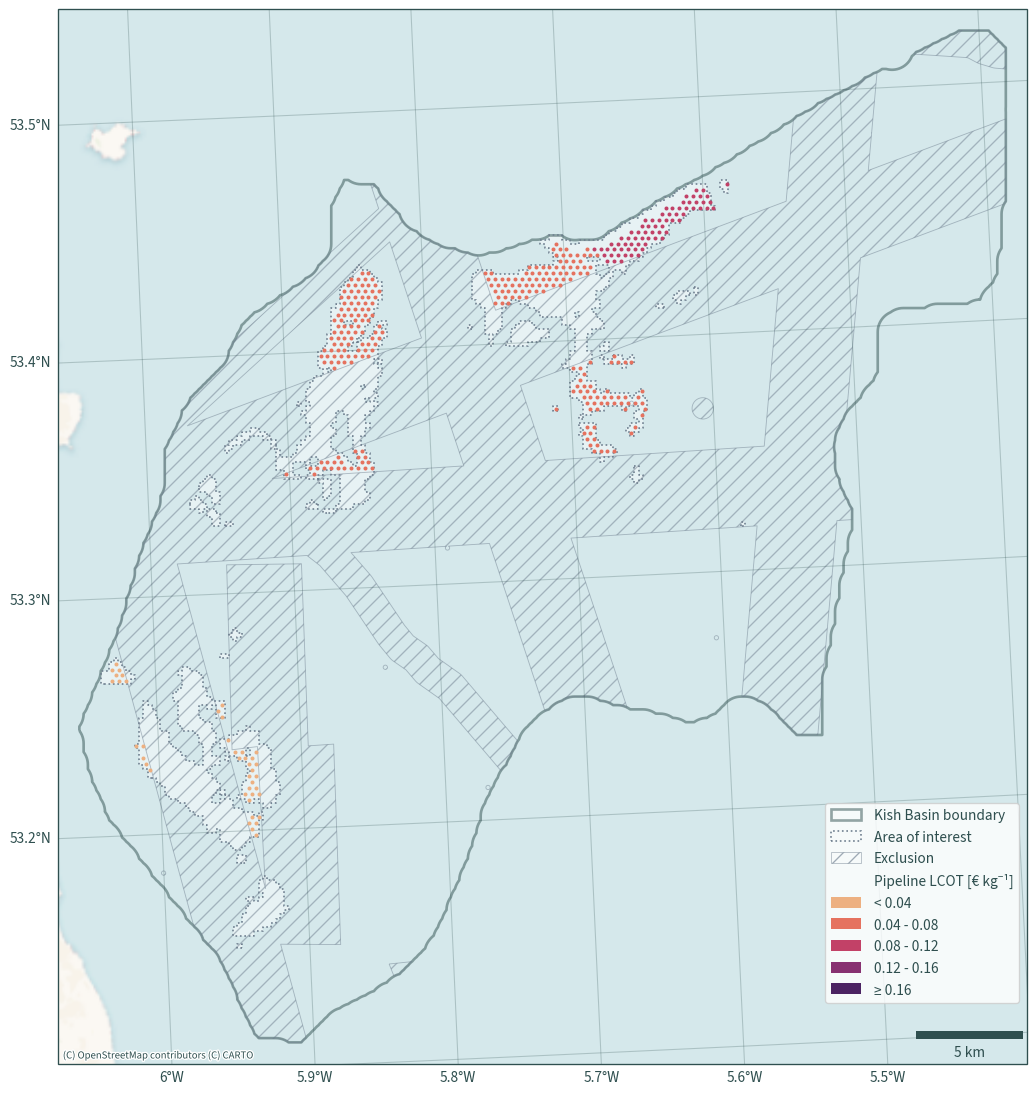

Dublin


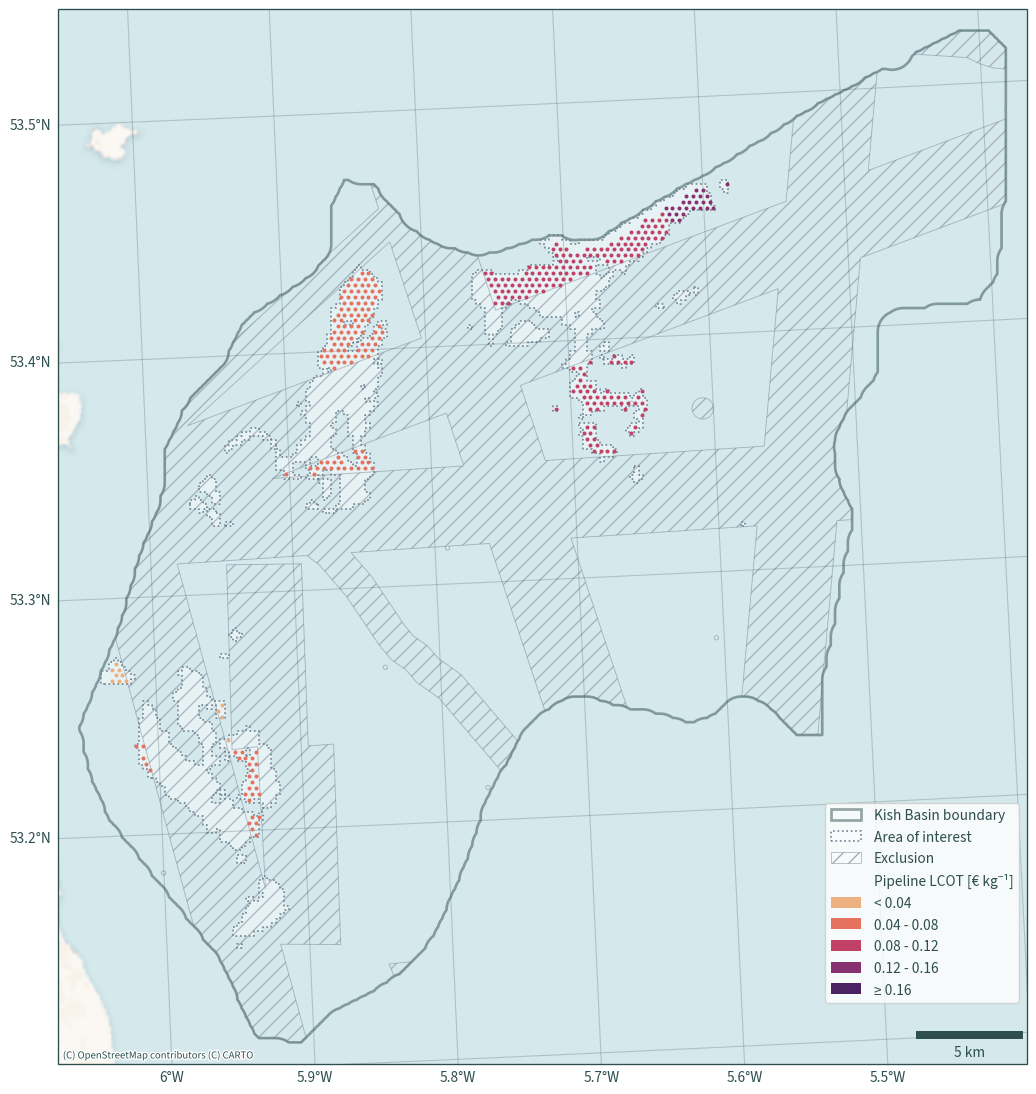

NISA


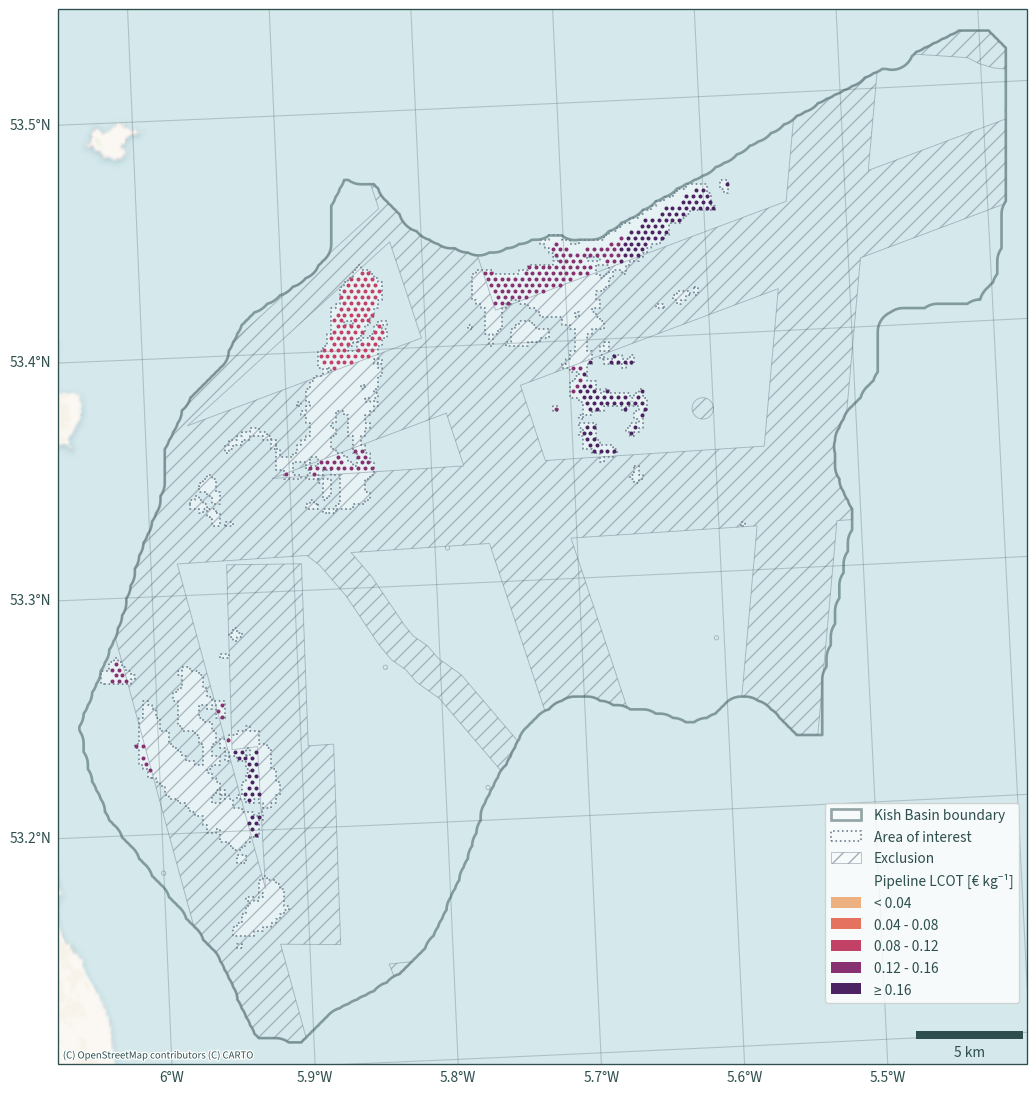

In [49]:
for wf in ["Codling", "Dublin", "NISA"]:
    print(wf)
    plot_map_alt(
        ds,
        caverns,
        zones,
        f"LCOT_{wf}",
        [0.04 * n for n in range(5)],
        [0] + [int(256 / 4) + int(256 / 4) * n - 1 for n in range(4)],
        ["< 0.04", "0.04 - 0.08", "0.08 - 0.12", "0.12 - 0.16", "≥ 0.16"],
    )